# Scenario 2
## Background
(copied from scenario 2 description)

_The Delta variant is beginning to spread around the country, including in New York
state. Vaccine campaigns have been underway in select groups since the early part of 2021, but
the distribution process has a long tail and is still ongoing._

**Assumptions:**
- Children 0-10 cannot be vaccinated
- Let 𝑅(0) = 𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑖𝑣𝑒 𝑖𝑛𝑓𝑒𝑐𝑡𝑖𝑜𝑛𝑠 – 𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑖𝑣𝑒 𝑑𝑒𝑎𝑡ℎ𝑠, as of July 15 th , 2021.
- Let 𝐸(0) = 𝐼(0)/4
- Let 𝑆(0) = 𝑁 – 𝐸(0) − 𝐼(0) − 𝑅(0) − 𝐻(0) − 𝐷(0)

## Get model from scenario1

In [1]:
# Imports & setup
import sympy
from copy import deepcopy as _d
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

# Units
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# Concepts
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}),
    'H': Concept(name='H', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C25179'}),
    'D': Concept(name='D', units=person_units(), identifiers={'ncit': 'C28554'}),
}

# From scenario description
N_val = 19_340_000

# I(0) from data-truth/truth-Cumulative Cases.csv @ https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
I_val = 2123452

# D(0) from data-truth/truth-Cumulative Deaths.csv @ https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
D_val = 53550

# H(0) from CSV at https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
# Column used: 'inpatient_beds_used_covid' for state == 'NY' and date == '2021/07/15'
H_val = 744

# Derived initial values according to evaluation description
E_val = I_val/4
R_val = I_val - D_val
S_val = N_val - E_val - I_val - R_val - H_val - D_val

# NOTE: Some parameter values are updated from Scenario 1
parameters = {
    'beta': Parameter(name='beta', value=0.8, units=per_day_per_person_units()),
    'r_E_to_I': Parameter(name='r_E_to_I', value=0.2, units=per_day_units()),
    'r_I_to_H': Parameter(name='r_I_to_H', value=0.1, units=per_day_units()),
    'p_I_to_H': Parameter(name='p_I_to_H', value=0.1, units=dimensionless_units()),
    'r_I_to_R': Parameter(name='r_I_to_R', value=0.07, units=per_day_units()),
    'p_I_to_R': Parameter(name='p_I_to_R', value=0.9, units=dimensionless_units()),
    'r_H_to_R': Parameter(name='r_H_to_R', value=0.1, units=per_day_units()),
    'p_H_to_R': Parameter(name='p_H_to_R', value=0.85, units=dimensionless_units()),
    'r_H_to_D': Parameter(name='r_H_to_D', value=0.1, units=per_day_units()),
    'p_H_to_D': Parameter(name='p_H_to_D', value=0.15, units=dimensionless_units()),
    'N': Parameter(name='N', value=N_val, units=person_units()),
}


initials = {
    'S': Initial(concept=Concept(name='S'), value=S_val),
    'E': Initial(concept=Concept(name='E'), value=E_val),
    'I': Initial(concept=Concept(name='I'), value=I_val),
    'R': Initial(concept=Concept(name='R'), value=R_val),
    'H': Initial(concept=Concept(name='H'), value=H_val),
    'D': Initial(concept=Concept(name='D'), value=D_val),
}

observables = {}

S, E, I, R, D, H, N, beta, r_E_to_I, r_E_to_H, r_I_to_H, p_I_to_H, r_I_to_R, p_I_to_R, r_H_to_R, p_H_to_R, r_H_to_D, p_H_to_D = \
    sympy.symbols('S E I R D H N beta r_E_to_I r_E_to_H r_I_to_H p_I_to_H r_I_to_R p_I_to_R r_H_to_R p_H_to_R r_H_to_D p_H_to_D')



In [2]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*beta / N)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=r_E_to_I*E)
t3 = NaturalConversion(subject=c['I'],
                       outcome=c['R'],
                       rate_law=r_I_to_R*p_I_to_R*I)
t4 = NaturalConversion(subject=c['I'],
                       outcome=c['H'],
                       rate_law=r_I_to_H*p_I_to_H*I)
t5 = NaturalConversion(subject=c['H'],
                       outcome=c['R'],
                       rate_law=r_H_to_R*p_H_to_R*H)
t6 = NaturalConversion(subject=c['H'],
                       outcome=c['D'],
                       rate_law=r_H_to_D*p_H_to_D*H)
templates = [t1, t2, t3, t4, t5, t6]
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Evaluation Scenario 2 Base model')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario2_base.json')

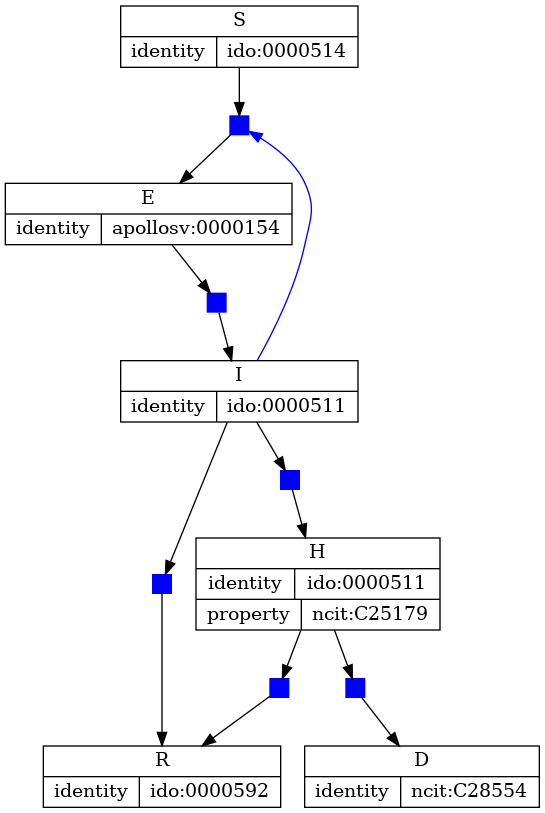

In [3]:
GraphicalModel.for_jupyter(tm)

## Question 1 - Update Scenario1 model
Update the model from Scenario 1 to have multiple vaccination compartments, one per vaccine (moderna, pfizer, J&J). For the mRNA vaccines, consider the number of primary series doses (1 or 2). Children ages 0-10 are not eligible for vaccination. Include masking (masked vs unmasked) for the unvaccinated population.

In [4]:
# Stratify the by vaccination status...
tm_vaccinated = stratify(
    tm,
    key='vaccinated',
    strata=['unvaccinated', 'vaccinated'],
    structure=[['unvaccinated', 'vaccinated']],
    cartesian_control=True,
    directed=True,
    # Only beta is modified by vaccination status (see question 1c)
    params_to_stratify={'beta'},
    # Don't stratify Death/Deceased
    concepts_to_stratify={"S", "E", "I", "R", "H"},
)
# ...the vaccinated by vaccine...
tm_vaccinated2 = stratify(
    tm_vaccinated,
    key='vaccinated',
    strata=['pfizer', 'moderna', 'j_and_j'],
    structure=[],
    cartesian_control=True,
    directed=True,
    # Only the beta parameters are modified by vaccination status (see question 1c)
    params_to_stratify={p for p in tm_vaccinated.parameters if p.startswith('beta')},
    concepts_to_stratify={c.name for c in tm_vaccinated.get_concepts_name_map().values()
                          if c.name.endswith('_vaccinated')}
)

# ...and the mRNA vaccinated by number of primary series dosing
tm_vaccinated3 = stratify(
    tm_vaccinated2,
    key='dose',
    strata=['1dose', '2dose'],
    structure=[['1dose', '2dose']],
    cartesian_control=True,
    directed=True,
    # Only beta is modified by vaccination status (see question 1c)
    params_to_stratify={'beta'},
    concepts_to_stratify={c.name for c in tm_vaccinated2.get_concepts_name_map().values()
                          if c.name.endswith(('_moderna', '_pfizer'))}
)

# Delete direct transitions unvaccinated -> 2 dose
transitions_to_delete = {t.get_key() for t in tm_vaccinated3.templates
                         if isinstance(t, NaturalConversion)
                         and t.subject.name.endswith('unvaccinated')
                         and t.outcome.name.endswith('2dose')}

print(f"Found {len(transitions_to_delete)} illegal transitions:")

# Sort out the corresponding templates
templates_to_keep = [t for t in tm_vaccinated3.templates if t.get_key() not in transitions_to_delete]
print(f"Reducing model to {len(templates_to_keep)} transitions")

# Replace current list of templates
tm_vaccinated3.templates = templates_to_keep

Found 10 illegal transitions:
Reducing model to 190 transitions


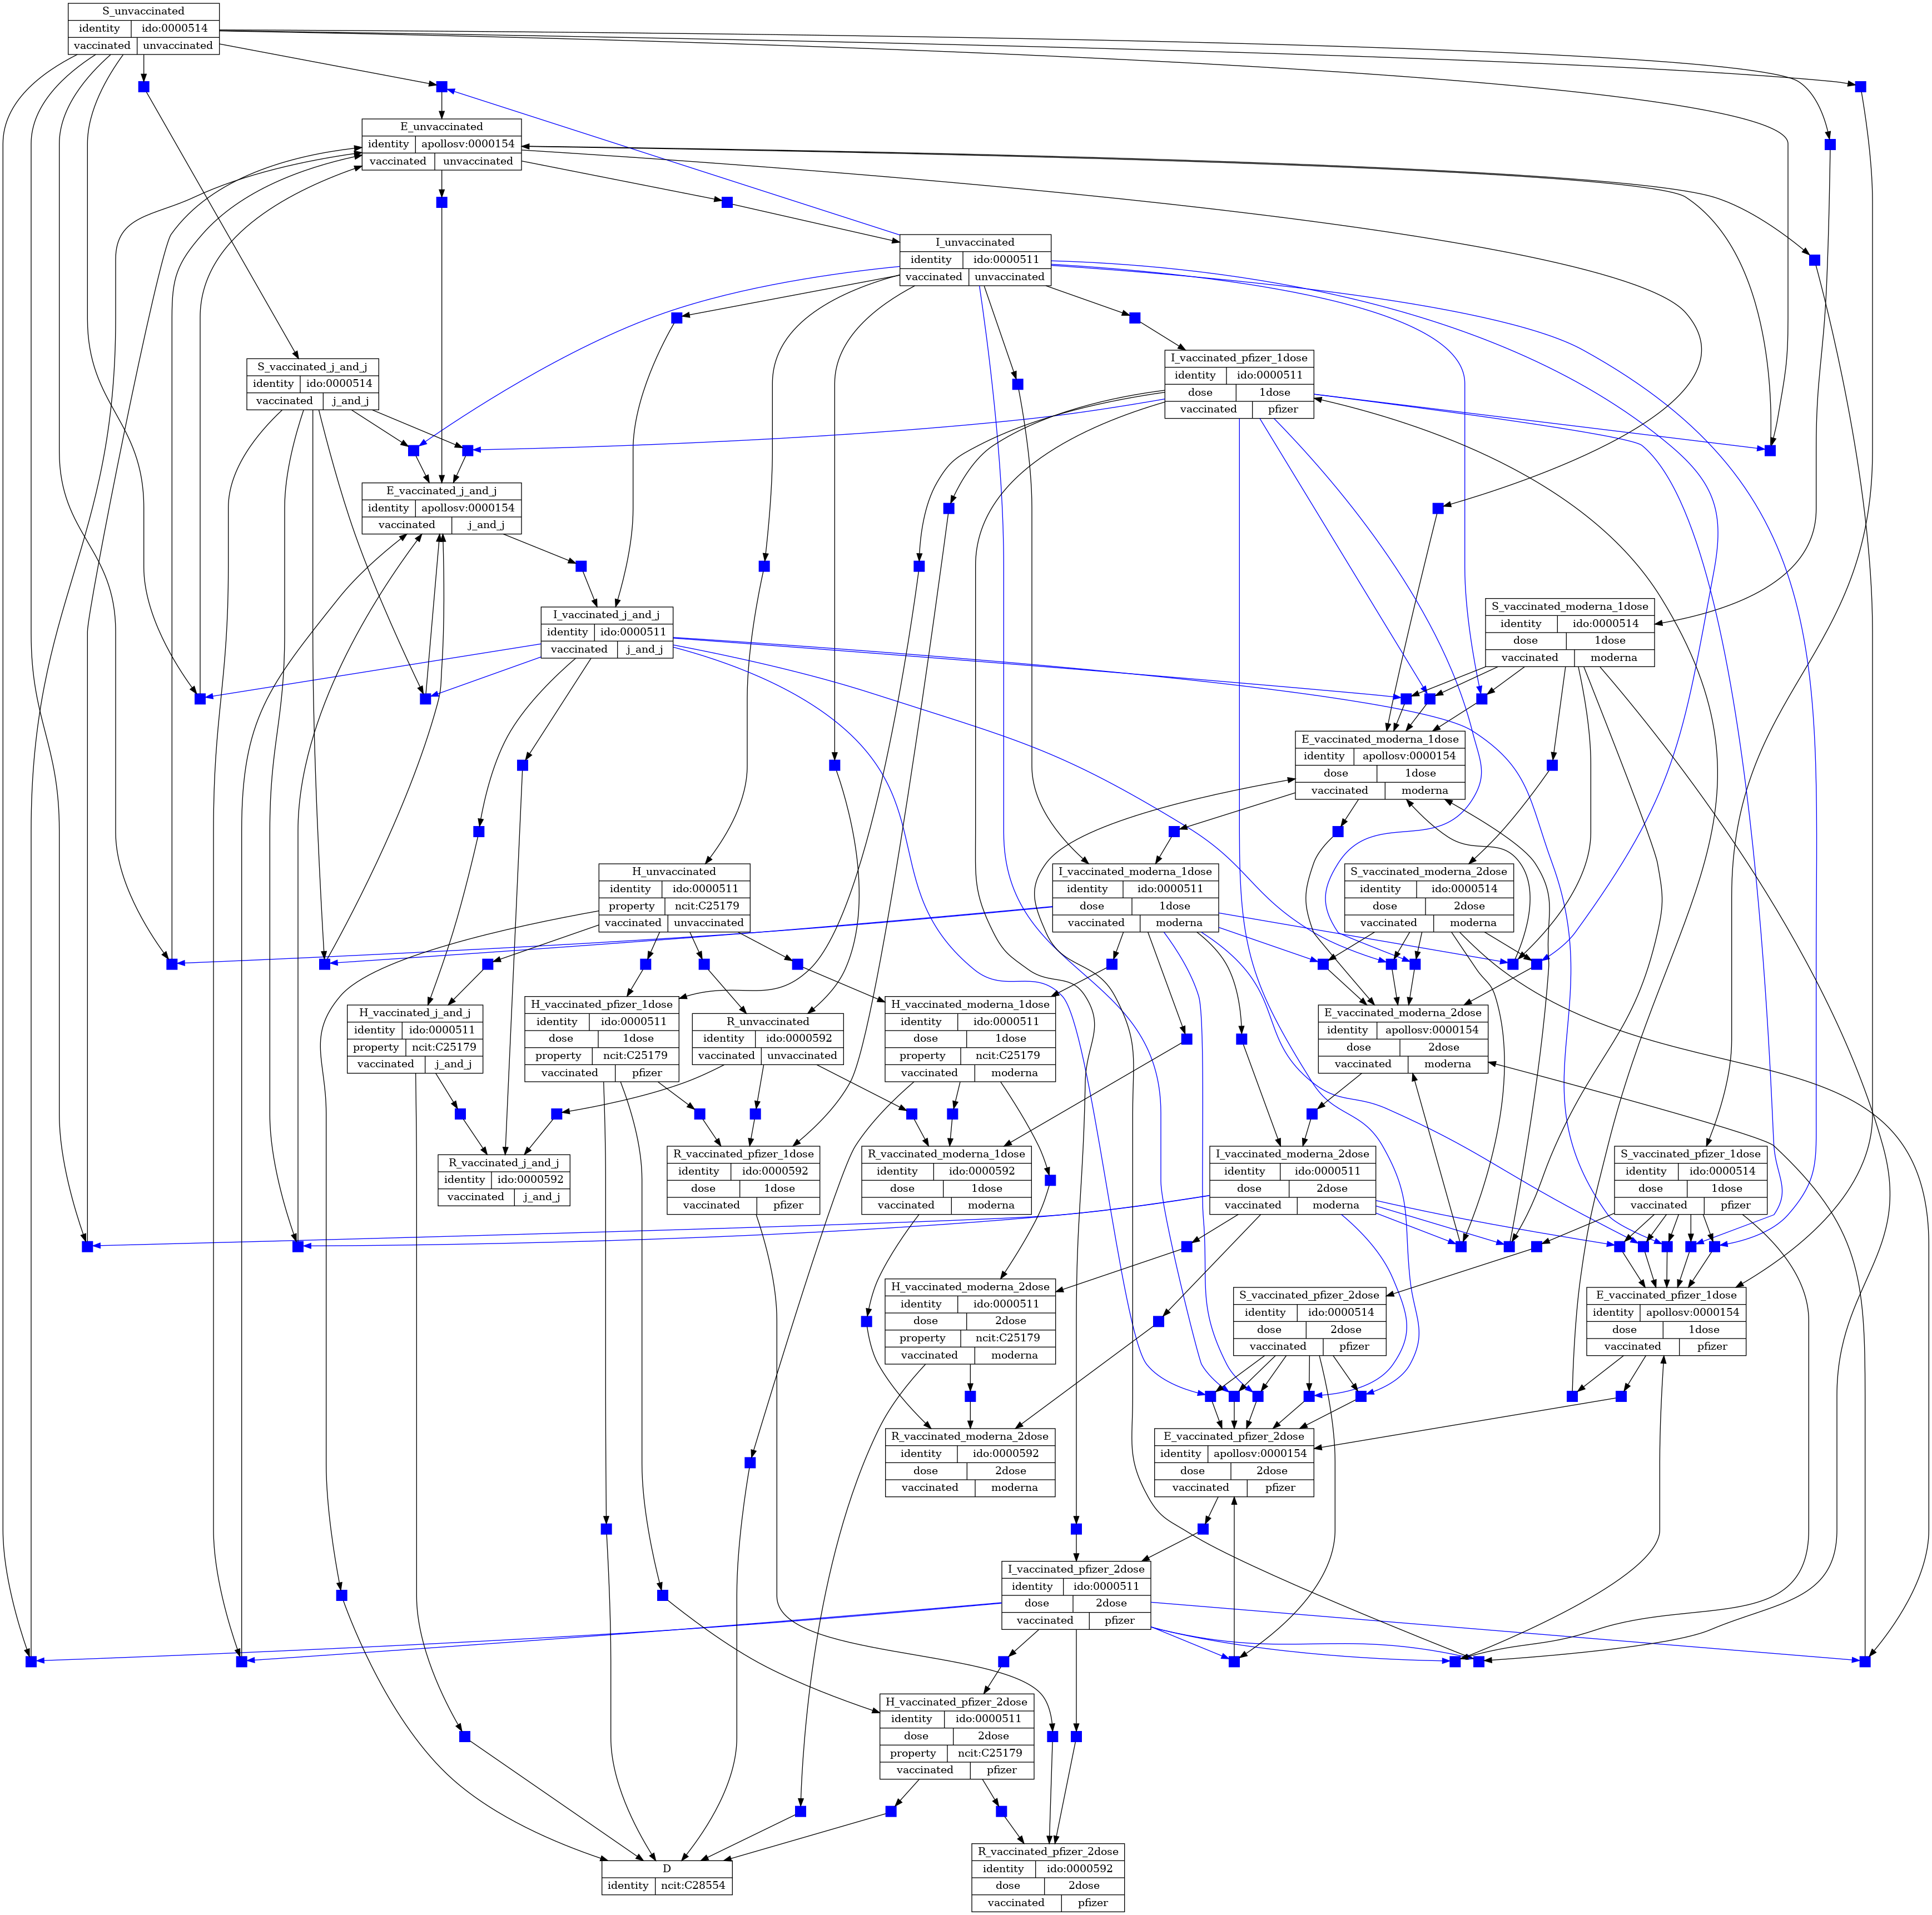

In [5]:
# Draw model
GraphicalModel.for_jupyter(tm_vaccinated3)

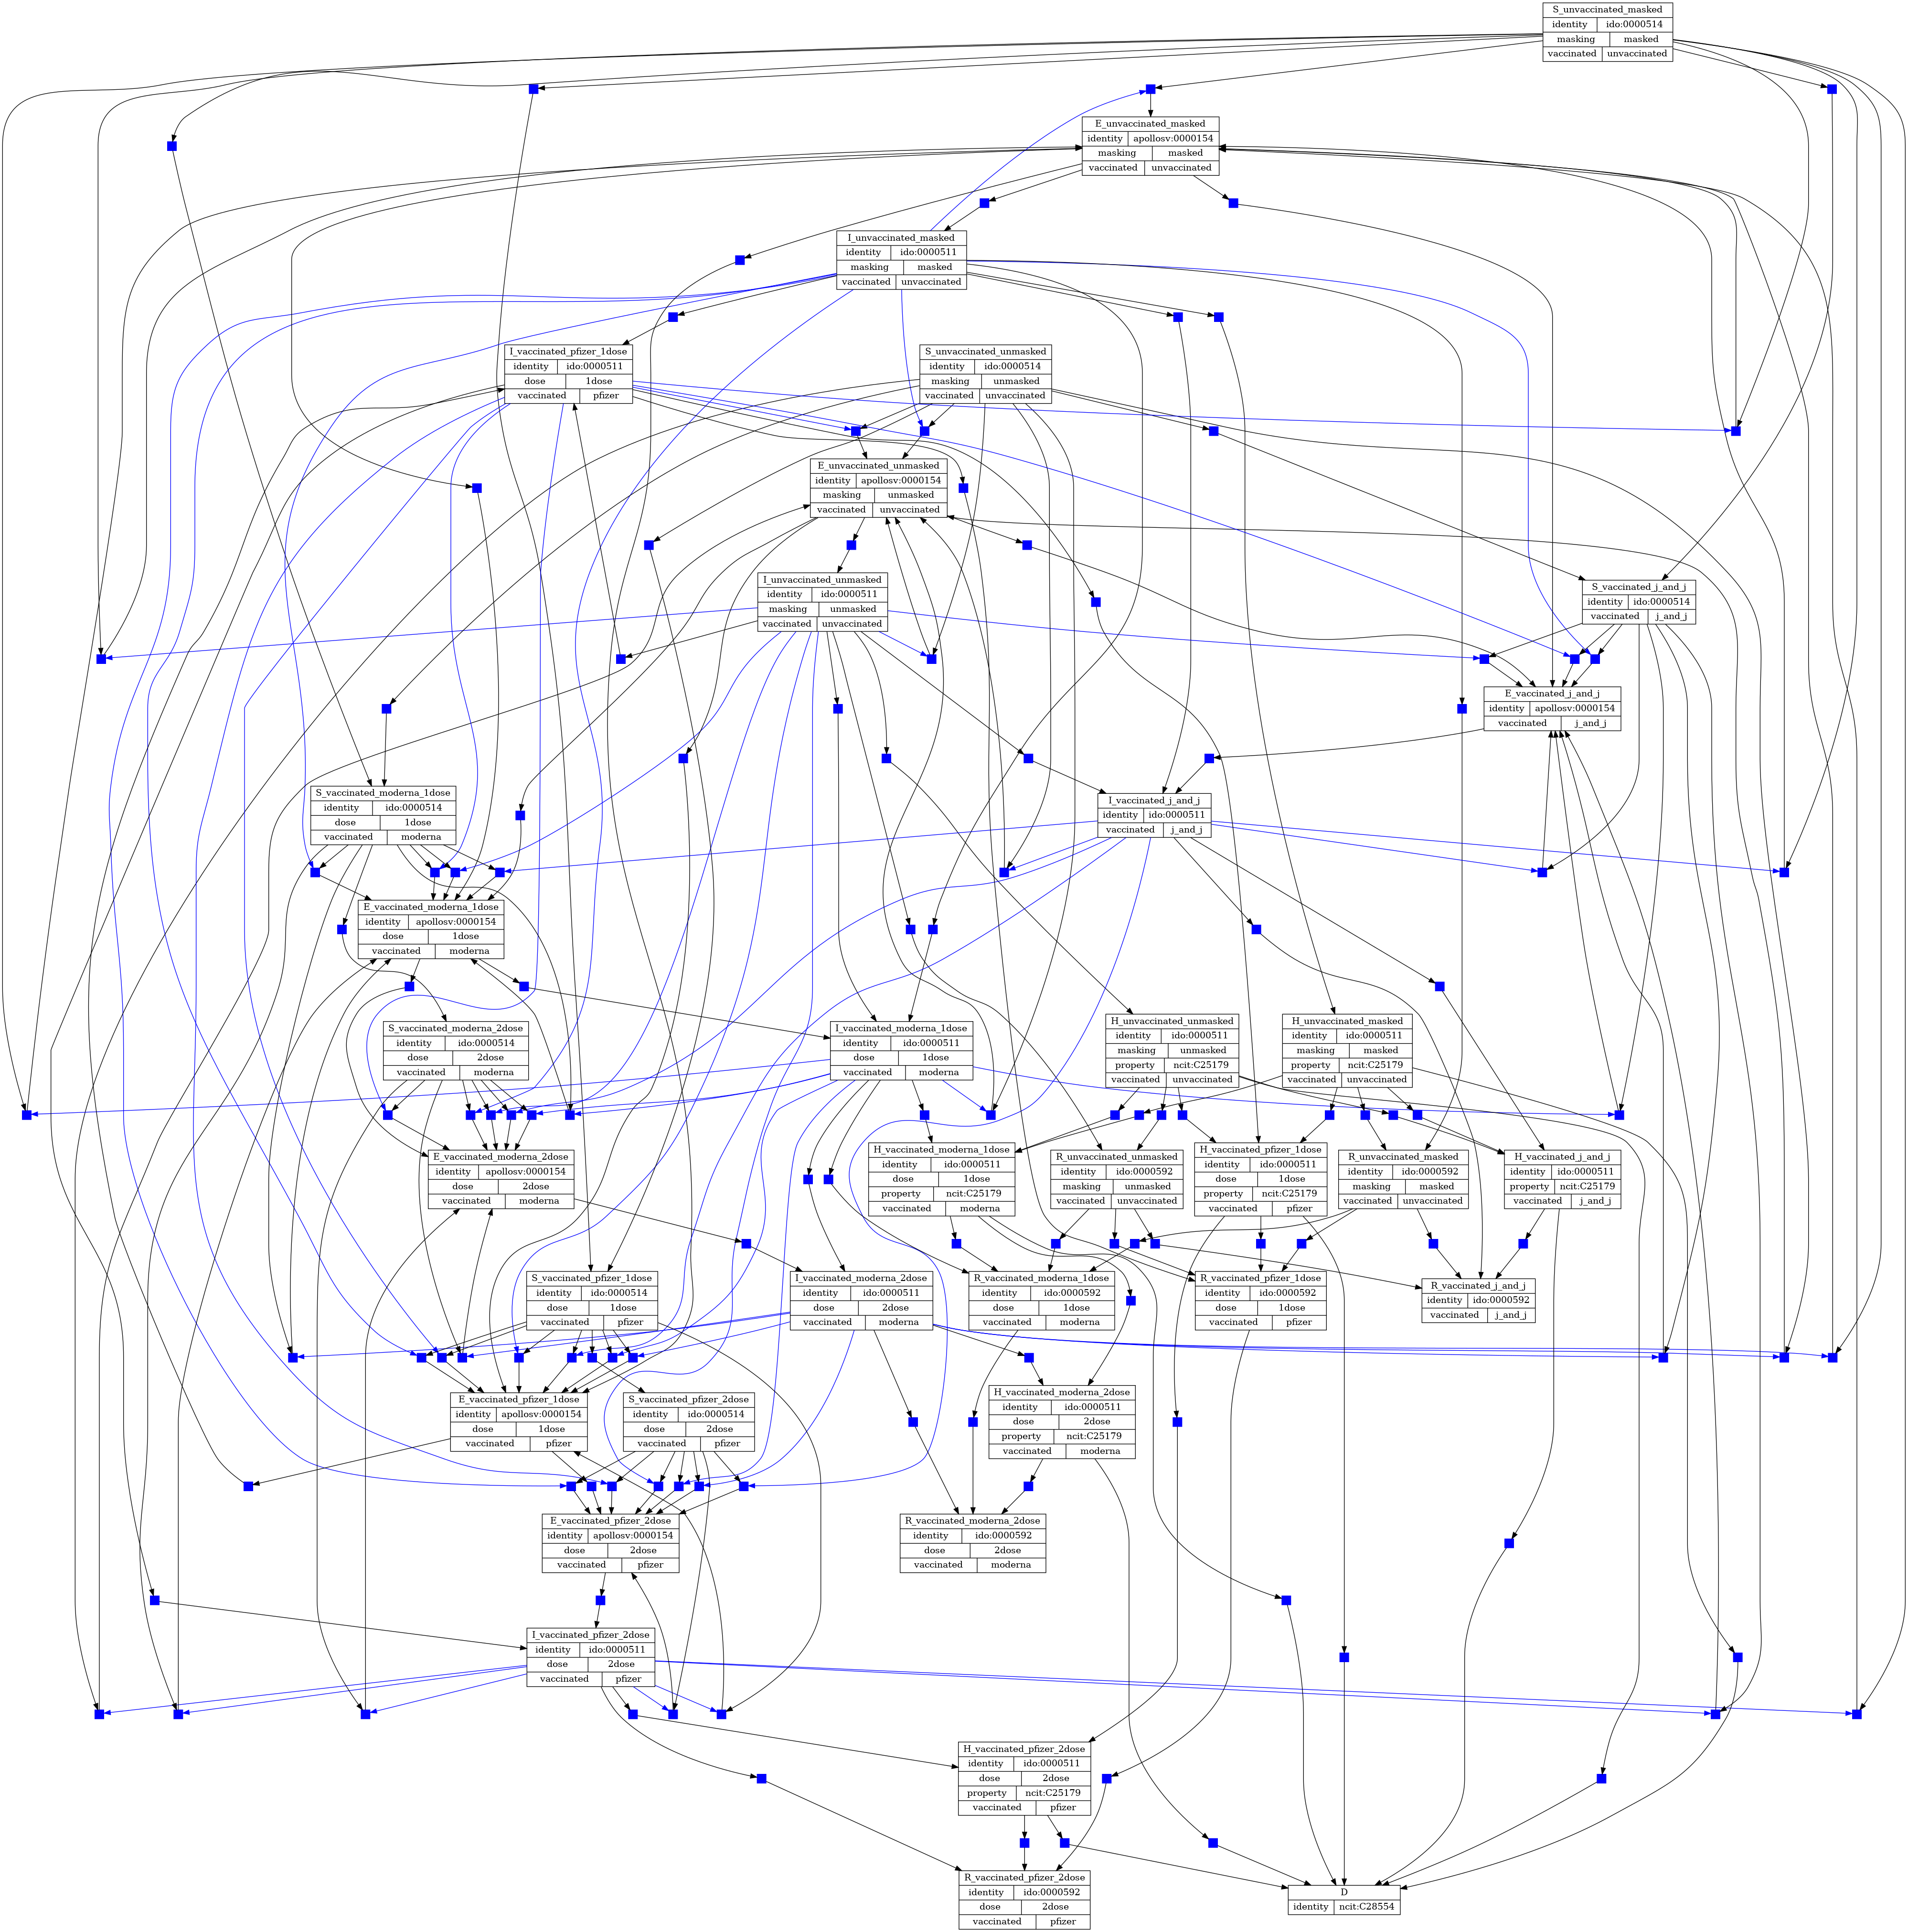

In [6]:
# Stratify unvaccinated by masking compliance
tm_q1_b = stratify(
    tm_vaccinated3,
    key='masking',
    strata=['masked', 'unmasked'],
    structure=[],
    cartesian_control=True,
    # Stratify unvaccinated only, skip Dead/Deceased
    concepts_to_stratify={c for c in tm_vaccinated3.get_concepts_name_map()
                          if c.endswith('unvaccinated') and not c.startswith('D')},
    params_to_preserve={'N'}
)
GraphicalModel.for_jupyter(tm_q1_b)

In [7]:
AskeNetPetriNetModel(Model(tm_q1_b)).to_json_file('eval_scenario2_1_b.json')

## Question 2 - Age stratification
To separate out school-aged people from those who aren’t school-aged, stratify the model into three age groups: those aged 0-9, corresponding to those in school or daycare who cannot be vaccinated; those aged 10-19, corresponding to those in school settings who can be vaccinated; and those aged 20 and above, corresponding
to those outside of the school setting. \[...\] For school openings, assume that all β values for school-aged kids are increased by 1.5x.

In [8]:
# Stratify by age groups 0-9, 10-19, 20+
# First, stratify the unvaccinated to the three age groups for all concepts
tm_unvacc_age = stratify(
    tm_q1_b,
    key='age',
    strata=['0_9', '10_19', '20'],
    structure=[],
    cartesian_control=True,
    concepts_to_stratify={
        c for c in tm_q1_b.get_concepts_name_map()
        if 'unvaccinated' in c or c.startswith('D')
    },
    params_to_preserve={'N'}
)
GraphicalModel.from_template_model(tm_unvacc_age).write('eval_scenario2_2_unvacc_age.png')

# Now stratify the vaccinated by 10-19 and 20+
tm_q2_a = stratify(
    tm_unvacc_age,
    key='age',
    strata=['10_19', '20'],
    structure=[],
    cartesian_control=True,
    # Death/Deceased already stratified above, skip
    concepts_to_stratify={
        c for c in tm_q1_b.get_concepts_name_map()
        if any(vp in c for vp in ['pfizer', 'moderna', 'j_and_j']) and not c.startswith('D')
    },
    params_to_preserve={'N'}
)


import itertools
def _illegal_transition(t: Template) -> bool:
    # No transitions between age groups allowed
    ages = ['0_9', '10_19', '20']
    if isinstance(t, NaturalConversion):
        for ag1, ag2 in itertools.permutations(ages, 2):
            if t.subject.name.endswith(ag1) and t.outcome.name.endswith(ag2):
                return True
    return False


# Sort out the templates with illegal transitions
templates_to_keep = [t for t in tm_q2_a.templates if not _illegal_transition(t)]
print(f"Reducing model to {len(templates_to_keep)} transitions")

# Replace current list of templates
tm_q2_a.templates = templates_to_keep

GraphicalModel.from_template_model(tm_q2_a).write('eval_scenario2_2_a.png')
AskeNetPetriNetModel(Model(tm_q2_a)).to_json_file('eval_scenario2_2_a.json')

Reducing model to 10760 transitions
